In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("monthly-milk-production.csv").set_index('Month')

In [3]:
data.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
#Make the index a time series by using
data.index = pd.to_datetime(data.index)

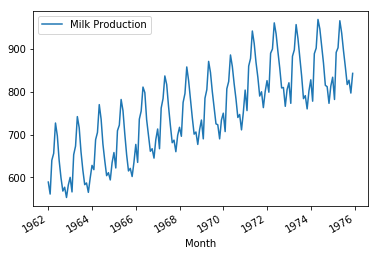

In [5]:
data.plot()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


### Split Data

In [7]:
# We are going to attempt a predict a year's worth of data (12 months or 12 steps)
num_of_timesteps = 12

#head = first years
train_set = data.head(len(data)-num_of_timesteps) # we could do same thing by slicing it using the iloc]\

#tail = last years
test_set = data.tail(num_of_timesteps)

### Scale the Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(train_set)

### Batch Function

In [10]:
def next_batch(training_data, batch_size, num_of_timesteps):
    """
    input : Data, Batch Size, Time Steps per batch
    output : A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    # STEP 1: Set a random starting point index for the batch
    # Each batch needs have the same number of steps in it.
    # Means that limit the starting point to len(data) - steps
    rand_start = np.random.randint(0, len(training_data)-num_of_timesteps)
    
    y_batch = np.array(training_data[rand_start:rand_start+num_of_timesteps+1]).reshape(1, num_of_timesteps+1)
    
    # Return the batches. We will have two batches to return y[:,:-1] and y[:,1:]
    # We will need to reshape these into tensors for the RNN to reshape(-1, num_of_steps, 1)
    return y_batch[:,:-1].reshape(-1, num_of_timesteps, 1), y_batch[:,1:].reshape(-1, num_of_timesteps, 1)

### RNN Model

In [11]:
import tensorflow as tf

/home/jackalhan/Development/github/more_meaningful_representations/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
# Constants # hyperparameters
num_of_inputs = 1
num_of_neurons = 200
num_of_outputs = 1
learning_rate = 0.001
num_of_training_iterations = 10000
batch_size = 1

In [13]:
# placeholders
X = tf.placeholder(tf.float32, [None, num_of_timesteps, num_of_inputs])
y = tf.placeholder(tf.float32, [None, num_of_timesteps, num_of_outputs])

In [14]:
cell = tf.contrib.rnn.GRUCell(num_units=num_of_neurons, activation=tf.nn.relu)
# we are just predicting one output here, we just want one time series output
# number of neurons we are using here is 100, so we do not want 100 outputs
# we need to project this kust to be one, the way we can do is using output projection wrapper
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_of_outputs)

In [15]:
# it is going to automatically ouput both the outputs and the states of this cells
# it performs a dynamic unrolling of the inputs that basically just means
# it is using a while loop operation to run over the cell the approp. number of times.
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32)

In [16]:
# Loss Function
loss = tf.reduce_mean(tf.square(outputs-y))

In [17]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# Training
train = optimizer.minimize(loss)

In [18]:
init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)
# saver function to save our model 
saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto(gpu_options =gpu_options)) as sess:
    sess.run(init)
    for i in range(num_of_training_iterations):
        X_batch, y_batch = next_batch(train_scaled, batch_size, num_of_timesteps)
        sess.run(train, feed_dict={X:X_batch, y:y_batch})
        if i % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            # we could also pass the test data
            print(i, '\tmse', mse)
    saver.save(sess, './models/my_ex_time_series_model')
        

0 	mse 0.0880037
100 	mse 0.027243352
200 	mse 0.017217493
300 	mse 0.011863633
400 	mse 0.009557906
500 	mse 0.012569647
600 	mse 0.008289387
700 	mse 0.0071855
800 	mse 0.008012796
900 	mse 0.0055947304
1000 	mse 0.005564954
1100 	mse 0.004666599
1200 	mse 0.006674262
1300 	mse 0.005146006
1400 	mse 0.00537608
1500 	mse 0.0067884587
1600 	mse 0.0066897143
1700 	mse 0.006616466
1800 	mse 0.0029783824
1900 	mse 0.006666006
2000 	mse 0.005290285
2100 	mse 0.0055002887
2200 	mse 0.00670235
2300 	mse 0.008807168
2400 	mse 0.0063469023
2500 	mse 0.0027643591
2600 	mse 0.0044385153
2700 	mse 0.0046701063
2800 	mse 0.0049694125
2900 	mse 0.0015425108
3000 	mse 0.0066187363
3100 	mse 0.005446064
3200 	mse 0.0035279605
3300 	mse 0.005179729
3400 	mse 0.003942004
3500 	mse 0.0025752413
3600 	mse 0.0037575008
3700 	mse 0.0051704394
3800 	mse 0.003060202
3900 	mse 0.004830842
4000 	mse 0.001567802
4100 	mse 0.0026465012
4200 	mse 0.0042314376
4300 	mse 0.0047673285
4400 	mse 0.002386813
4500 	mse

### Predict the Future

In [19]:
test_set

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


In [20]:
# We want to predict these 12 months of data, using onl the training data we had. 
# To do that we fill feed in a seed training_instance of the last 12 months of the training_set of data
# to predict 12 months in the future. Then we will be able to compare our generated 12 months to our actual true gistorical values
# from the test set

### Generative Session

In [21]:
with tf.Session() as sess:
    saver.restore(sess, './models/my_ex_time_series_model')
    
    seq_seed_and_predictions = list(train_scaled[-num_of_timesteps:])
    for iteration in range(num_of_timesteps):
        X_batch = np.array(seq_seed_and_predictions[-num_of_timesteps:]).reshape(1, num_of_timesteps,1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        # I am trying to get the 30 zeros and then generated values
        # always get the value from the last item of y predictions
        seq_seed_and_predictions.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./models/my_ex_time_series_model


In [22]:
seq_seed_and_predictions

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.6665873,
 0.56394464,
 0.8410789,
 0.8999931,
 1.1102042,
 1.0394357,
 0.91543686,
 0.8160296,
 0.7012029,
 0.665829,
 0.5768703,
 0.64733255]

In [23]:
#grab the portion of the results that are the generated values and apply inverse_transform on them
# to turn them back to milk production value units (lbs per cow). ALSO reshape the results to be (12,1)
# so we can easily add them to the test dataframe

In [24]:
results = scaler.inverse_transform(np.array(seq_seed_and_predictions[-num_of_timesteps:]).reshape(num_of_timesteps,1))

In [25]:
test_set['Generated'] = results

/home/jackalhan/Development/github/more_meaningful_representations/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,830.300293
1975-02-01 01:00:00,782.0,787.600952
1975-03-01 01:00:00,892.0,902.888855
1975-04-01 01:00:00,903.0,927.397156
1975-05-01 01:00:00,966.0,1014.844910
1975-06-01 01:00:00,937.0,985.405273
1975-07-01 01:00:00,896.0,933.821777
1975-08-01 01:00:00,858.0,892.468262
1975-09-01 01:00:00,817.0,844.700378


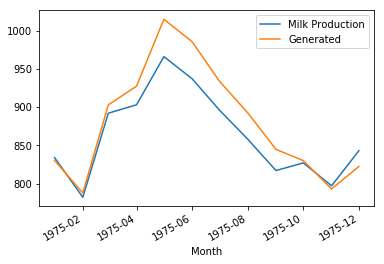

In [27]:
test_set.plot()